In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
import statsmodels.api as sm

mpl.rcParams['figure.figsize'] = (10,7)
plt.style.use('ggplot')


Bad key "text.kerning_factor" on line 4 in
/home/grepehu/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [25]:
data_a1 = pd.read_csv('dados_a1_a.csv')
new_names = {'vt_mV':'$V_t (mV)$' , 'deltat_c': '$\Delta T (^oC)$' ,
             'i_ma_taumen': '$I_1 (mA)$' , 'v_v_taumen': '$V_1 (V)$',
            'i_ma_taumen2': '$I_2 (mA)$' , 'v_v_taumen2': '$V_2 (V)$',
            'i_ma_tdim': '$I_3 (mA)$' , 'v_v_tdim': '$V_3 (V)$',}

# Dados da Primeira Parte

Nos dados abaixo temos dois tipos de medida, de corrente em mA e de tensão em V. Estas medidas foram feitas em três sets, dois com a temperatura aumentando (1 e 2) e um com a temperatura diminuindo (3). 

Em todos os casos a temperatura foi medida através de um termopar que indica a variação de 10 ºC a cada 0,4 mV de variação.

In [26]:
#Renomeando as colunas para serem mais legíveis
data_a1.rename(columns=new_names,inplace= True)
data_a1

,$V_t (mV)$,$\Delta T (^oC)$,$I_1 (mA)$,$V_1 (V)$,$I_2 (mA)$,$V_2 (V)$,$I_3 (mA)$,$V_3 (V)$
0,0.0,0,9.41,12.155,9.24,12.389,8.91,12.588
1,0.4,10,11.74,10.680,11.41,11.002,12.81,10.137
2,0.8,20,14.32,9.044,14.15,9.273,15.48,8.452
3,1.2,30,16.73,7.527,16.47,7.820,17.87,6.951
4,1.6,40,18.77,6.245,18.69,6.392,19.96,5.626
5,2.0,50,20.56,5.107,20.60,5.186,21.72,4.518
6,2.4,60,22.15,4.113,22.19,4.191,23.10,3.652
7,2.8,70,23.40,3.290,23.54,3.344,24.25,2.923
8,3.2,80,24.44,2.659,24.64,2.659,25.15,2.355
9,3.6,90,25.23,2.147,25.41,2.165,25.84,1.922


Podemos agora fazer os valores médios para estas correntes e tensões em cada variação de temperatura.

E aproveitar e introduzir o erro da temperatura, uma vez que este derivada da medição do erro do termopar.

In [4]:
#Erro da temperatura já em Kelvin
t = (0.0001)*(10/0.0004)
    
t

2.5

In [43]:
#Criando o dataframe pra média
data_avg = pd.DataFrame()

#Adicionando as colunas da temperatura, I e V médio
data_avg['$\Delta T (^oC)$'] = data_a1['$\Delta T (^oC)$']
data_avg['$\overline{I} (mA)$'] = ((data_a1['$I_1 (mA)$'] + data_a1['$I_2 (mA)$'] + data_a1['$I_3 (mA)$'])/3).round(2)
data_avg['$\overline{V} (V)$'] = ((data_a1['$V_1 (V)$']+data_a1['$V_2 (V)$']+data_a1['$V_3 (V)$'])/3).round(3)
data_avg

## Condutividade x Temperatura Absoluta

Na tabela abaixo podemos montar um relação entre a temperatura absoluta em K, pela condutância média do material, pois sabemos que a temperatura inicial do ambiente era de 22 ºC (295 K).

Condutância por sua vez se calcula com:

\begin{equation*}G=\frac{I}{V}\end{equation*}

E condutividade como:

\begin{equation*}\sigma(T)=\sigma_{\infty}e^{-\frac{E_g}{2K_b\, T}}\end{equation*}

A condutância e a condutividade por sua vez se relacionam como:

\begin{equation*}G=\frac{A\sigma(T)}{L}\end{equation*}

Então condutividade pode ser escrita como:

\begin{equation*}\sigma(T)=\frac{IL}{VA}\end{equation*}

Com isso podemos encontrar os valores de cada ponto para a condutividade, uma vez que conhecemos o tamanho da peça semi-condutora de $L = 20,0\pm 0,05 \,mm$ e $A = (10,0\pm 0,05) \times (1,00\pm 0,005) = 10,0 \pm 0,1 \, mm^2$.

In [6]:
#Esta função calcula o erro da condutividade
#Aqui os valores foram passados de mA para A e de mm para m (mm² para m² também)
def error_condut( i , v , l=0.020 , a=0.000010):
    term1 = (0.00001)*l/(v*a)
    term2 = (0.00005)*(i*0.001)/(v*a)
    term3 = (0.001)*(i*0.001)*l/((v**2)*a)
    term4 = (0.0000001)*(i*0.001)*l/(v*(a**2))
    
    return term1 + term2 + term3 + term4

In [7]:
#Criando dataframe para a condutividade
data_condut = pd.DataFrame()

#Criando a coluna da temperatura abosluta somando a temperatura ambiente à variação
data_condut['$T \,(K)$'] = data_avg['$\Delta T (^oC)$'] + 295

#Criando coluna da condutividade com base nos calculos acima
data_condut['$\sigma\, (\Omega^{-1}\,m^{-1})$'] = (data_avg['$\overline{I} (mA)$'] / (0.5 * data_avg['$\overline{V} (V)$'])).round(2)

#Criando a coluna com os erros da condutividade
data_condut['$\Delta\sigma$'] = [ error_condut(i,v) for 
                                 i,v in zip(data_avg['$\overline{I} (mA)$'] , 
                                                data_avg['$\overline{V} (V)$'])]
data_condut['$\Delta\sigma$'] = data_condut['$\Delta\sigma$'].round(2)

In [45]:
data_condut

,"$T \,(K)$","$\sigma\, (\Omega^{-1}\,m^{-1})$",$\Delta\sigma$
0,295,1.49,0.02
1,305,2.26,0.03
2,315,3.28,0.04
3,325,4.58,0.06
4,335,6.29,0.08
5,345,8.49,0.11
6,355,11.28,0.15
7,365,14.90,0.20
8,375,19.34,0.26
9,385,24.53,0.33


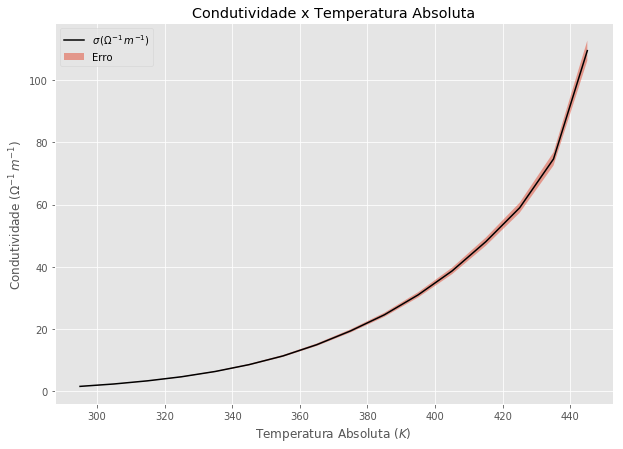

In [50]:
fig1, ax1 = plt.subplots(figsize=(10,7))

#Plotando os dados em si
ax1.plot(data_condut['$T \,(K)$'], 
         data_condut['$\sigma\, (\Omega^{-1}\,m^{-1})$'],
         c='k')

#Plotando a sombra de erro
ax1.fill_between(data_condut['$T \,(K)$'], 
                 data_condut['$\sigma\, (\Omega^{-1}\,m^{-1})$']-data_condut['$\Delta\sigma$'], 
                 data_condut['$\sigma\, (\Omega^{-1}\,m^{-1})$']+data_condut['$\Delta\sigma$'], alpha=0.5 , label='Erro')

#Adicionando titulo e legenda
ax1.set_title('Condutividade x Temperatura Absoluta')
ax1.set_xlabel('Temperatura Absoluta ($K$)')
ax1.set_ylabel('Condutividade ($\Omega^{-1}\,m^{-1}$)')

ax1.legend(loc=0)

## Linearização

Como já vimos anteriormente a condutividade se relaciona com a temperatura absoluta da forma:

\begin{equation*}\sigma(T)=\sigma_{\infty}e^{-\frac{E_g}{2K_b\, T}}\end{equation*}

Aplicando $Ln$ dos dois lados desta equação ficamos com:

\begin{equation*}Ln(\sigma)=Ln(\sigma_{\infty})-\frac{E_g}{2K_b}T^{-1}\end{equation*}

Chamando de $y = Ln(\sigma)$ e $x = T^{-1}$, podemos linearizar esta equação:

\begin{equation*}y=Ln(\sigma_{\infty})-\frac{E_g}{2K_b}x\end{equation*}

In [10]:
#Funções que calculam o erro de y e x
def erro_x(t):
    return 2.5/(t**2)

def erro_y(sig,errs):
    return errs/sig

In [52]:
data_lin = pd.DataFrame()

data_lin['$y$'] = [np.log(i) for i in data_condut['$\sigma\, (\Omega^{-1}\,m^{-1})$']]
data_lin['$y$'] = data_lin['$y$'].round(3)

data_lin['$\Delta y$'] = [erro_y(sig,errs) for sig,errs in zip(data_condut['$\sigma\, (\Omega^{-1}\,m^{-1})$'], 
                                               data_condut['$\Delta\sigma$'])]
data_lin['$\Delta y$'] = data_lin['$\Delta y$'].round(3)

data_lin['$x$'] = [float(t)**(-1) for t in data_condut['$T \,(K)$']]

data_lin['$\Delta x$'] = [erro_x(i) for i in data_condut['$T \,(K)$']]

data_lin

,$y$,$\Delta y$,$x$,$\Delta x$
0,0.399,0.013,0.003390,0.000029
1,0.815,0.013,0.003279,0.000027
2,1.188,0.012,0.003175,0.000025
3,1.522,0.013,0.003077,0.000024
4,1.839,0.013,0.002985,0.000022
5,2.139,0.013,0.002899,0.000021
6,2.423,0.013,0.002817,0.000020
7,2.701,0.013,0.002740,0.000019
8,2.962,0.013,0.002667,0.000018
9,3.200,0.013,0.002597,0.000017


In [12]:
#Preparando dados para regressão linear
x = np.array(data_lin['$x$']).reshape(-1,1)
y = np.array(data_lin['$y$']).reshape(-1,1)
err = np.array(data_lin['$\Delta y$']).reshape(-1,1)

reta = LinearRegression().fit(x,y)

#Obtendo dados desta reta
print("Precisão da regressão:", (round(reta.score(x,y),4)))
print("Coeficiente Angular da reta:", round(reta.coef_[0][0],2))
print("Coeficiente Linear da reta:", round(reta.intercept_[0],2))
print("Erro Médio Absoluto:", round(mae(x,reta.predict(x)),2))

Precisão da regressão: 0.998
Coeficiente Angular da reta: -3601.71
Coeficiente Linear da reta: 12.59
Erro Médio Absoluto: 2.7


In [13]:
#Preparando uma segunda regressão linear com um modelo melhor

#Esse modelo não tem valor de constante linear para reta por padrão, então tem de ser adicionado
X = sm.add_constant(x)

#Coloando os dados. Detalhe que primeiro se coloca os valores de y e depois de x neste modelo
reta2 = sm.OLS(y,X).fit()

#Obtendo dados desta reta
reta2.summary()

/home/grepehu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     6819.
Date:                Sun, 07 Mar 2021   Prob (F-statistic):           3.18e-20
Time:                        13:58:41   Log-Likelihood:                 23.163
No. Observations:                  16   AIC:                            -42.33
Df Residuals:                      14   BIC:                            -40.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5918      0.121    104.301      0.000      12.333      12.851
x1         -3601.7113     43.616    -82.577      0.000   -3695.259   -3508.163
==============================================================================
Omnibus:                       28.445   Durbin-Watson:                   0.804
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.116
Skew:                           2.524   Prob(JB):                     4.34e-10
Kurtosis:                       9.261   Cond. No.                     2.87e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

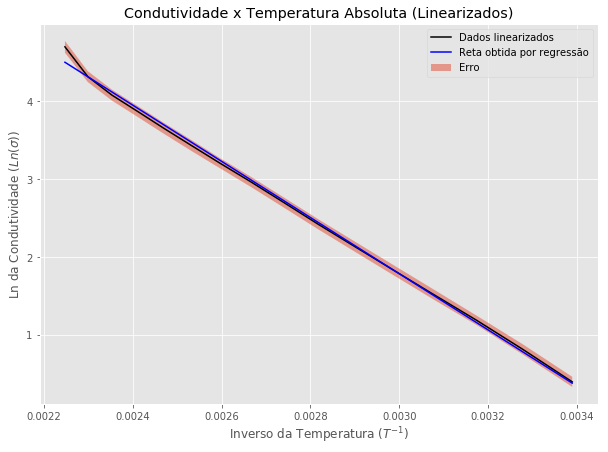

In [56]:
fig2, ax2 = plt.subplots(figsize=(10,7))

#Plotando a sombra do erro dos dados
ax2.fill_between(data_lin['$x$'], 
                 data_lin['$y$']-5*data_lin['$\Delta y$'], 
                 data_lin['$y$']+5*data_lin['$\Delta y$'], alpha = 0.5, 
                 label='Erro')

#Plotando os dados linearizados
ax2.plot(x,y, label='Dados linearizados', c='k')


#Plotando a reta obtida da regressão
ax2.plot(x,reta.predict(x), label='Reta obtida por regressão',c='b')


#Colocando os enfeites do gráfico
ax2.set_title('Condutividade x Temperatura Absoluta (Linearizados)')
ax2.set_xlabel('Inverso da Temperatura $(T^{-1})$')
ax2.set_ylabel('Ln da Condutividade $(Ln(\sigma))$')
ax2.legend(loc=0)

In [15]:
#Calculando o erro da energia de gap
erro_eg = 2*(8.62)*(10**(-5))*(40) + 2*(3600)*(10**(-5))*(0.01)

erro_eg

0.0076159999999999995

Assim a reta que obtemos é dada por:

\begin{equation*}y=(12.6 \pm 0,1) -(3600 \pm 40)x\end{equation*}

E a nossa equação é:

\begin{equation*}y=Ln(\sigma_{\infty})-\frac{E_g}{2K_b}x\end{equation*}

Assim temos que:

\begin{equation*}Ln(\sigma_{\infty})=12.6 \quad ; \quad \frac{E_g}{2K_b} = 3600\end{equation*}

Com isso e sabendo o valor da constante de Bolztmann $(8.62\pm 0.01 \times 10^{-5} \,eV)$, podemo encontrar o valor da energia de gap:

\begin{equation*}E_g = 2K_b \times 3600 = 2 \times 8.62 \times 10^{-5} \times 3600 = 0,62 eV \end{equation*}

Assim encontramos o valor de gap de $0,62\pm 0,01\, eV$, enquanto o valor tabelado é dado por $0,67\, eV$.

# Dados da Segunda Parte

Nesta parte temos medidas de campo magnetico variando de $50$ em $50\, mT$ ($\pm 1\, mT$) enquanto medimos a tensão em V que obtemos atráves de três amostras, uma de Germânio puro ($Ge$) sob uma corrente de $25\, mA$ e duas de Germânio dopado ($n-Ge$ e $p-Ge$) sob a corrente de $35\, mA$.

In [57]:
data_a1b = pd.read_csv('dados_a1_b.csv')
new_names2 = {'indumag_b_mt':'$B\, (mT)$' , 'v_ge_v': '$V_{Ge}\, (V)$' ,
              'v_nge_v': '$V_{Ge}^{n} \, (V)$' ,'v_pge_v': '$V_{Ge}^{p}\, (V)$' }

#Renomeando as colunas para serem mais legíveis
data_a1b.rename(columns=new_names2,inplace= True)
data_a1b

,"$B\, (mT)$","$V_{Ge}\, (V)$","$V_{Ge}^{n} \, (V)$","$V_{Ge}^{p}\, (V)$"
0,0,16.228,1.4603,1.5738
1,50,17.834,1.4648,1.5767
2,100,17.936,1.4703,1.5810
3,150,18.010,1.4743,1.5890
4,200,18.072,1.4796,1.5979
5,250,18.200,1.4852,1.6105
6,300,18.252,1.4916,1.6221
7,350,18.425,1.5015,1.6356
8,400,18.550,1.5094,1.6490


## Resistência

Vamos agora dividir as tensões por suas correntas respectivas e obtermos uma relação entre o campo aplicado e a resistência do material.

In [60]:
data_res = pd.DataFrame()

data_res['$B\, (mT)$'] = data_a1b.iloc[:,0]
data_res['$R_{Ge}\, (\Omega)$'] = ((data_a1b.iloc[:,1]*1000)/25).round(2)
data_res['$R_{Ge}^{n}\, (\Omega)$'] = ((data_a1b.iloc[:,2]*1000)/35).round(2)
data_res['$R_{Ge}^{p}\, (\Omega)$'] = ((data_a1b.iloc[:,3]*1000)/35).round(2)

data_res

,"$B\, (mT)$","$R_{Ge}\, (\Omega)$","$R_{Ge}^{n}\, (\Omega)$","$R_{Ge}^{p}\, (\Omega)$"
0,0,649.12,41.72,44.97
1,50,713.36,41.85,45.05
2,100,717.44,42.01,45.17
3,150,720.40,42.12,45.40
4,200,722.88,42.27,45.65
5,250,728.00,42.43,46.01
6,300,730.08,42.62,46.35
7,350,737.00,42.90,46.73
8,400,742.00,43.13,47.11


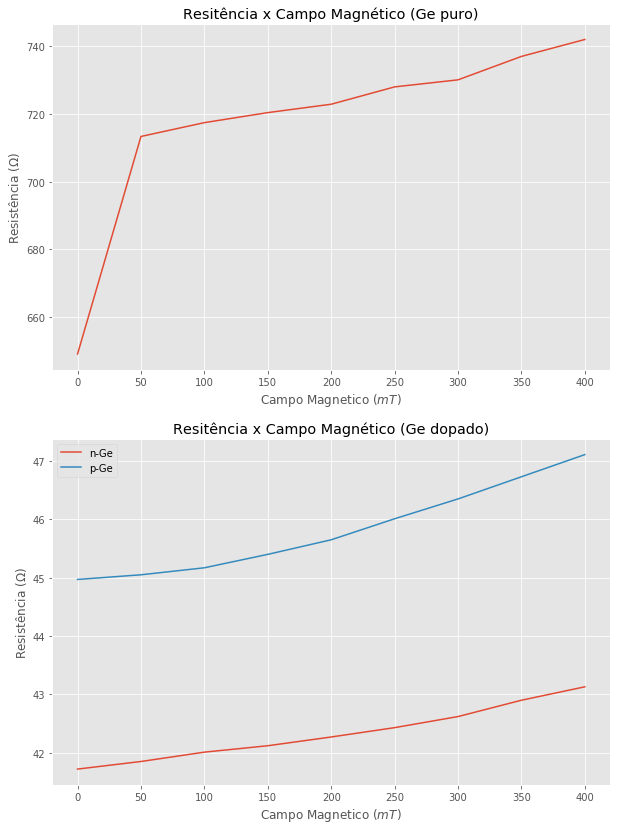

In [62]:
fig3, ax3 = plt.subplots(nrows = 2, figsize=(10,14))

#Plotando os dados
ax3[0].plot(data_res.iloc[:,0], data_res.iloc[:,1])
ax3[1].plot(data_res.iloc[:,0], data_res.iloc[:,2], label='n-Ge')
ax3[1].plot(data_res.iloc[:,0], data_res.iloc[:,3], label='p-Ge')

#Enfeitando o gráfico
ax3[0].set_title('Resitência x Campo Magnético (Ge puro)')
ax3[0].set_xlabel('Campo Magnetico $(mT)$')
ax3[0].set_ylabel('Resistência $(\Omega)$')

ax3[1].set_title('Resitência x Campo Magnético (Ge dopado)')
ax3[1].set_xlabel('Campo Magnetico $(mT)$')
ax3[1].set_ylabel('Resistência $(\Omega)$')
ax3[1].legend(loc=0)

Fica evidente que o campo magnetico tem um ponto com medida muito abaixo do padrão esperado, então vou exclui-lo para o processo de modelagem polinomial de $R(B)$.

In [19]:
for degree in np.arange(7)[1:]:
    model_ge = np.poly1d(np.polyfit(data_res.iloc[1:,0],data_res.iloc[1:,1] , degree))

    print("R² do polinomio de grau %s: %.4f" % (degree, r2(data_res.iloc[1:,1], model_ge(data_res.iloc[1:,0]))) )

R² do polinomio de grau 1: 0.9811
R² do polinomio de grau 2: 0.9926
R² do polinomio de grau 3: 0.9948
R² do polinomio de grau 4: 0.9953
R² do polinomio de grau 5: 0.9953
R² do polinomio de grau 6: 0.9969


## Magnetoresitência

Apesar de sabermos que a resitência em semicondutores deve variar com o aumento do campo magnetico da forma:

\begin{equation*}R(B) = \alpha B^2 + \beta B + \gamma \end{equation*}

Porém utilizando a medida de precissão $R^2$ para a precissão do nosso modelo polinomial de $R(B)$ não é possível afirmar o grau de dependência de R com B desta forma.

## Erro provavel

https://www.niser.ac.in/sps/sites/default/files/basic_page/Magnetoresistance%20of%20Bismuth.pdf

https://www.niser.ac.in/